In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [2]:
import openturns as ot
import numpy as np
import openturns.viewer as viewer

from matplotlib import pylab as plt
from matplotlib.patches import Circle, Wedge, Polygon, Rectangle
from matplotlib.collections import PatchCollection
from matplotlib.font_manager import FontProperties

import math
from functools import partial
from joblib import Parallel, delayed
import shelve
import os

import otaf

In [3]:
# HELPER FUNCTIONS
# For plotting
x_min = -0.25
x_max = 0.7
n_points = int(1e4)

# Reference Analytical Example in 2D

To show the benefits of this approach compared to the usual ones, we apply it using a minimal isostatic example using only a reduced number of variables and having an analytical solution. As explained, the analysis consists of 6 steps : 
 - The definition of the mathematical model from the dimensions and feature type and tolerance value. 
 - The construction of the constraint function for the features
 - The construction of the probabilistic model using some quality criteria (sigma/6t smthing)
 - The generation of the design of experiment
 - The propagation of the uncertainty through the model.
 - The extraction of the upper and lower envelope of the response of the model. 

## Exploring the imprecise probability space. 

For the male piece, we know that in 95% of the cases, the value of X1 will be between X1 - X_tot < X1 < X1 + X_tol ,
but the uncertainty is originating from a combination of positional and orientation defects. We do  not know which is contributing more. 

Let's first explore how the sum of the defects behaves, when under the constraint of the 95%

Let's consider that the real measure of X1 is based on a base value and a sum of random modes:

$$
X_{1} = X1 + \mathcal{e}_{pos} + \mathcal{e}_{ori} \\
\mathcal{e}_{pos} + \mathcal{e}_{ori} <= X_{tol} \ (Dans\ 95\%\ des\ cas)
$$

![schema](../Pictures/Female_Male_Part.jpg)

##### Defining the dimensions and vriables for the problem

In [4]:
### Different measures of our problem
X1 = 99.8  # Nominal Length of the male piece
X2 = 100  # Nominal Length of the female piece
X3 = 10.0  # Nominal width of the pieces
j = X2 - X1  # Nominal play between pieces.
T = 0.2 * np.sqrt(2) # Tolerance for X1 and X2. (95% conform)  (= t/2)
t_ = T / 2

Cm = 1 # Process capability

##### Defining the max distributions parameters for the degrees of freedom of the features. 

As the features on both parts are identical with same tolerance value on them, the distributions are the same for both features.

The defects are centered, and the standard deviations can be easily found using the 6 sigma rule. 

These are the max values for the standard deviations of the degrees of freedom, and are only valid if all the other degrees of freedom variances are 0. But by multiplying the distributions by a scalar between 0 and 1, any valid value for the standard deviation can be obtained. 

THis has the advantage that samples of defects for each degree of freedom can be generated individually, and than scaled so that they respect the feature level constraint. This also makes different samples have similar stochastic charachteristics, so that less bias is introduced by the seed.

In [5]:
# Maximal translational defect
sigma_e_pos_max = T / (6 * Cm)
e_pos = ot.Normal(0, sigma_e_pos_max)
e_pos.setDescription(["e_pos"])

# Maximal rotational defect (using the small angle hypothesis)
theta_max = T / X3
sigma_theta_max = (2 * theta_max) / (
    6 * Cm
)
e_theta = ot.Normal(0, sigma_theta_max)
e_theta.setDescription(["e_theta"])

In [6]:
def analytical_assembly_model_1_5_D(sample_of_defects, round_val=12):
    """
    Calculate the minimum difference between the upper and lower gaps for a given set of defects.

    Parameters:
        sample_of_defects ot.Sample: random deviation vector in the form of a openturns Sample
        round_val (int, optional): Number of decimal places to round the result (default: 6).

    Returns:
        list: A list containing the minimum play/gap for each point in the random deviation array.

    """
    size = sample_of_defects.getSize()
    desc = sample_of_defects.getDescription()
    zero_array = np.zeros((size, 1)) #If one of the variables is not in the sample we set it to 0
    smpU1 = np.array(sample_of_defects.getMarginal(["u_d_1"])) if "u_d_1" in desc else zero_array
    smpG1 = np.array(sample_of_defects.getMarginal(["gamma_d_1"])) if "gamma_d_1" in desc else zero_array
    smpU2 = np.array(sample_of_defects.getMarginal(["u_d_2"])) if "u_d_2" in desc else zero_array
    smpG2 = np.array(sample_of_defects.getMarginal(["gamma_d_2"])) if "gamma_d_2" in desc else zero_array

    X1_tilde = np.asarray(
        [X1 + smpU1 - (X3 / 2) * smpG1, X1 + smpU1 + (X3 / 2) * smpG1]  # haut
    ) 

    X2_tilde = np.asarray(
        [X2 - smpU2 - (X3 / 2) * smpG2, X2 - smpU2 + (X3 / 2) * smpG2]  # bas
    )
    jeu = X2_tilde - X1_tilde
    jeu_min = np.expand_dims(np.squeeze(jeu.min(axis=0)), axis=1).round(round_val).tolist()
    return ot.Sample(jeu_min)

## Imprecise tolerance analysis without correlation. 

Here we perform the tolerance analysis by supposing that no correlations is present within degrees of freedom of the same feature. We know that :

$$\sigma_u^2 + \frac{h^2 \sigma_\gamma^2}{4} = \left(\frac{t}{6*C}\right)^2$$

And that :

$$\frac{t}{6*C} = \sigma_{u,max}= \sigma_{\gamma,max}\frac{h}{2}$$

And so we can introduce a parameter called lambda so that $\sigma_{u} = \lambda_u * \sigma_{u,max}$.

We will do the entire optimization etc in the space of lambda, as well as the sample of allocations in the space of lambda. 

We can then just multiply the samples by $\sqrt{\lambda}$

In [7]:
# Model the imprecise space of defect allocation with 2 features and 4 DOFs
# i corresponds to the first feature, j corresponds to the second feature
size_lambda = 7
idar = np.arange(size_lambda + 1)
lambda_2_ar = np.vstack([idar / size_lambda, 1 - idar / size_lambda]).T

# Generate all possible allocation combinations and compute their square roots
ij_list = np.sqrt(np.array([[np.append(lambda_2_ar[i], lambda_2_ar[j]) for i in idar] for j in idar]).reshape(-1, 4))

# Create a sample using OpenTURNS
lambda_sample_nocorr = ot.Sample(ij_list)

In [8]:
# Monte Carlo sample size and random generator seed
size_MC2 = int(1e5)
ot.RandomGenerator.SetSeed(888)

# Get the composed normal defect distribution
RandDeviationVect = otaf.distribution.get_composed_normal_defect_distribution(
    defect_names=["gamma_d_1", "u_d_1", "gamma_d_2", "u_d_2"],
    sigma_dict={"gamma_": sigma_theta_max, "u_": sigma_e_pos_max}
)

# Sample from the random deviation vector
max_defect_sample = RandDeviationVect.getSample(size_MC2)

# Compose the defect samples with the lambda samples
composed_defect_sample = otaf.sampling.compose_defects_with_lambdas(lambda_sample_nocorr, max_defect_sample)

# Compute the gap list and corresponding distributions
result_plays = [analytical_assembly_model_1_5_D(x) for x in composed_defect_sample]
play_distributions_nocorr = [ot.UserDefined(play) for play in result_plays]

In [9]:
# Helper functions for lambda position and formatting strings
get_pos_lambda = lambda i, ar: [ar[i, 1], ar[i, 3]]  # Extract specific lambda positions
get_lambda_str = lambda l: f"Allocation position piece 1: {l[0] * 100:.1f}%, piece 2: {l[1] * 100:.1f}%"

# Define interesting pairs of lambda values and their colors
pos_pairs = [[0.0, 0.0], [0.0, 1.0], [1.0, 0.0], [0.2, 0.8], [0.8, 0.2], [1.0, 1.0]]
pos_pair_cols = [["#FF00CD"], ["green"], ["orange"], ["#00FFF3"], ["yellow"], ["black"]]

# Find the indices corresponding to the interesting lambda pairs
pos_pair_idx = [i for i in range(len(ij_list)) if get_pos_lambda(i, ij_list) in pos_pairs]

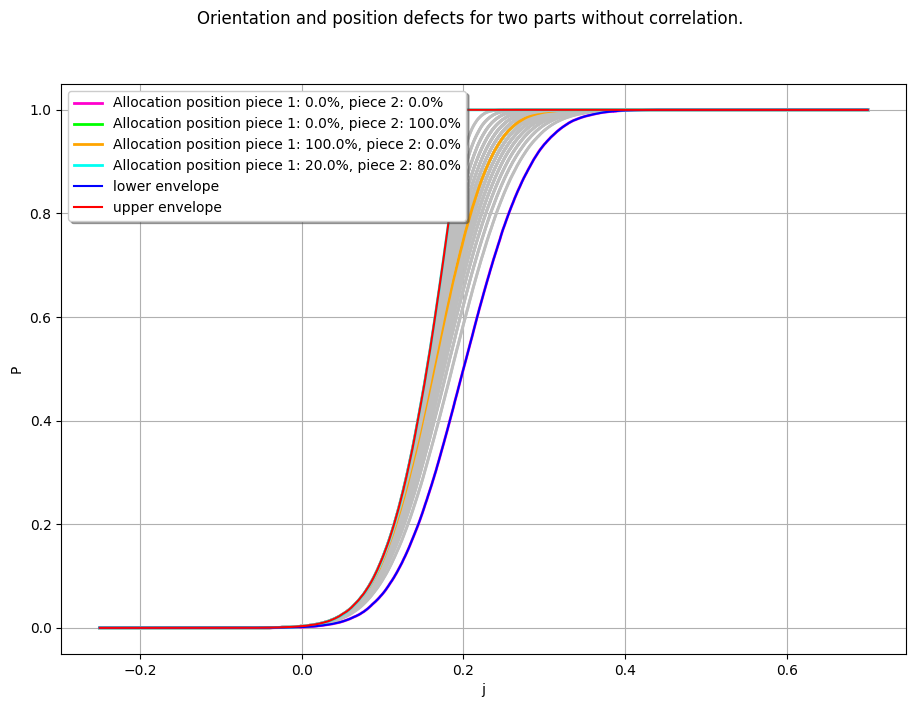

In [10]:
# Initialize colors and legends for each lambda sample
colors2 = [["grey"]] * lambda_sample_nocorr.getSize()
legends2 = [""] * lambda_sample_nocorr.getSize()

# Set colors and legends for interesting lambda pairs
for i, k in enumerate(pos_pair_idx):
    colors2[k] = pos_pair_cols[i]
    legends2[k] = get_lambda_str(pos_pairs[i])

# Compute the upper and lower envelopes of the distributions
sup_data_nocorr, inf_data_nocorr = otaf.distribution.compute_sup_inf_distributions(play_distributions_nocorr, x_min, x_max)

# Plot the combined CDF with additional curves for the envelopes
graph_full_2 = otaf.plotting.plot_combined_CDF(play_distributions_nocorr, x_min, x_max, colors2, legends2)
graph_full_2 = otaf.plotting.set_graph_legends(
    graph_full_2,
    x_title="j",
    y_title="P",
    title="Orientation and position defects for two parts without correlation.",
    legends=legends2
)

# Add the upper and lower envelopes to the graph
graph_full_2.add(ot.Curve(inf_data_nocorr, "blue", "solid", 1.5, "lower envelope"))
graph_full_2.add(ot.Curve(sup_data_nocorr, "red", "solid", 1.5, "upper envelope"))

# Display the final graph
view = ot.viewer.View(graph_full_2, pixelsize=(1100, 750))

In [11]:
pf_min = otaf.distribution.get_prob_below_threshold(inf_data_nocorr)
pf_max = otaf.distribution.get_prob_below_threshold(sup_data_nocorr)
print(f"Minimum failure probability: {pf_min:.5e}\n Maximum failure probability: {pf_max:.5e}")

Minimum failure probability: 1.49000e-03
 Maximum failure probability: 3.15000e-03


## Adding Correlations between degreers of freedom of the same features

Adding correlations between random variables introduces additional dimensions of imprecision. For `d` imperfections modeled and influenced by `λ` (lambda) coefficients, we can define `d-1` correlations if we wish to model them.

In [12]:
# Monte Carlo sample size and lambda/correlation settings
size_monte_carlo = int(1e5)

# Lambda sampling: creating a base array for the lambda space
size_lambda = 5
lambda_array = np.linspace(0, 1, size_lambda + 1)  # Simplified sampling of lambda space

# Correlation sampling: evenly spaced between -1 and 1
size_correlation = 5
correlation = np.linspace(-1 + 1e-7, 1 - 1e-7, size_correlation)  # Avoiding perfect correlation values

In [13]:
# Create a 4D grid of lambda and correlation combinations
lambda_indices = list(range(size_lambda + 1))
correlation_indices = list(range(size_correlation))

# Generate all combinations of lambda and correlation pairs
ijkz_list = np.array([
    [
        [
            [
                np.append([lambda_array[i], lambda_array[j]], [correlation[k], correlation[z]])
                for i in lambda_indices
            ]
            for j in lambda_indices
        ]
        for k in correlation_indices
    ]
    for z in correlation_indices
])

# Reshape the resulting array to create a combined lambda-correlation sample
ijkz_list = ijkz_list.reshape(-1, 4)  # Reshaping into a 2D array with 4 columns (λ₁, λ₂, correlation₁, correlation₂)

In [14]:
def compute_gap_with_lambdas_and_correlation(
    lmbd1, lmbd2, cor1, cor2, 
    lmb_arr=lambda_array, correlation=correlation, 
    SEED=888, N=size_monte_carlo
):
    """
    Compute the gap between two tilde values, influenced by lambda coefficients and correlations.
    
    Parameters:
    -----------
    lmbd1 : float
        Lambda value for the first sample.
    lmbd2 : float
        Lambda value for the second sample.
    cor1 : float
        Correlation coefficient for the first sample.
    cor2 : float
        Correlation coefficient for the second sample.
    lmb_arr : np.array
        Array of lambda values (default: lambda_array).
    correlation : np.array
        Array of correlation values (default: correlation).
    SEED : int
        Random seed for reproducibility.
    N : int
        Monte Carlo sample size.

    Returns:
    --------
    ot.Sample
        A sample of the computed gaps between X1_tilde and X2_tilde.
    """
    
    # Set random seed for reproducibility
    ot.RandomGenerator.SetSeed(SEED)
    
    # Generate correlated samples for both sets of imperfections
    smp1 = otaf.distribution.generate_correlated_samples(
        sigma1=sigma_e_pos_max, sigma2=sigma_theta_max, N=N, corr=cor1
    )
    smp2 = otaf.distribution.generate_correlated_samples(
        sigma1=sigma_e_pos_max, sigma2=sigma_theta_max, N=N, corr=cor2
    )
    
    # Extract positional and angular deviations
    e_pos_X1, e_theta1 = np.squeeze(smp1[:, 0]), np.squeeze(smp1[:, 1])
    e_pos_X2, e_theta2 = np.squeeze(smp2[:, 0]), np.squeeze(smp2[:, 1])
    
    # Compute X1_tilde and X2_tilde based on the lambda coefficients and deviations
    X1_tilde = np.array([
        X1 + np.sqrt(lmbd1) * e_pos_X1 - np.sqrt(1 - lmbd1) * (X3 / 2) * e_theta1,
        X1 + np.sqrt(lmbd1) * e_pos_X1 + np.sqrt(1 - lmbd1) * (X3 / 2) * e_theta1,
    ])
    
    X2_tilde = np.array([
        X2 - np.sqrt(lmbd2) * e_pos_X2 - np.sqrt(1 - lmbd2) * (X3 / 2) * e_theta2,
        X2 - np.sqrt(lmbd2) * e_pos_X2 + np.sqrt(1 - lmbd2) * (X3 / 2) * e_theta2,
    ])
    
    # Compute the gap (jeu) between X2_tilde and X1_tilde
    jeu = X2_tilde - X1_tilde
    jeu = np.expand_dims(np.squeeze(jeu.min(axis=0)), axis=1)
    
    # Return the result as an OpenTURNS sample
    return ot.Sample(jeu)


# Create a partial function with fixed parameters for lambda_array, correlation, and Monte Carlo size
compute_gap_func = partial(
    compute_gap_with_lambdas_and_correlation, 
    lmb_arr=lambda_array, correlation=correlation, 
    SEED=168406047, N=size_monte_carlo
)

# Apply the function to each combination in the lambda-correlation grid
ijkz_results = Parallel(n_jobs=-1)(delayed(compute_gap_func)(i, j, k, z) for i, j, k, z in ijkz_list)

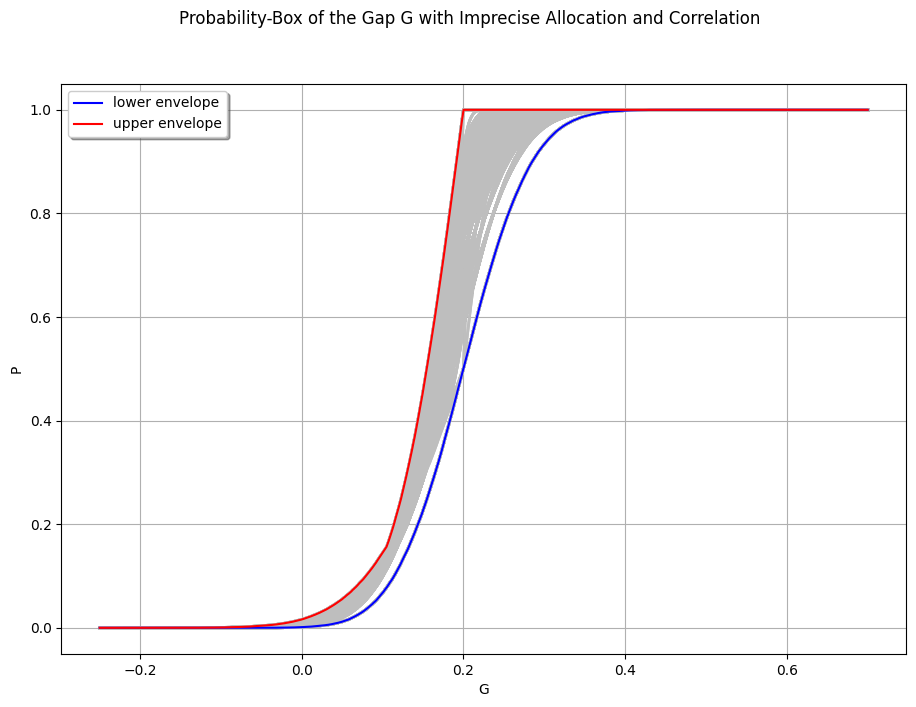

In [15]:
# Create distributions from the results of the gap function
#distributions3 = list(map(ot.UserDefined, ijkz_results))
distributions3 = Parallel(n_jobs=-1)(delayed(ot.UserDefined)(result) for result in ijkz_results)

# Initialize color and legend settings for each result
colors3 = [["grey"] for _ in ijkz_results]
legends3 = ["" for _ in ijkz_results]

# Compute the supremum and infimum data from the distributions
sup_data_corr, inf_data_corr = otaf.distribution.compute_sup_inf_distributions(distributions3, x_min, x_max)

# Create a combined CDF graph for the distributions    odel.

graph_full_3 = otaf.plotting.plot_combined_CDF(distributions3, x_min, x_max, colors3, legends3)

# Set the title and legends for the graph
title = "Probability-Box of the Gap G with Imprecise Allocation and Correlation"
graph_full_3 = otaf.plotting.set_graph_legends(
    graph_full_3, 
    x_title="G", 
    y_title="P", 
    title=title, 
    legends=[""] * len(ijkz_results)
)

# Add the lower and upper envelopes (infimum and supremum) to the graph
graph_full_3.add(ot.Curve(inf_data_corr, "blue", "solid", 1.5, "lower envelope"))
graph_full_3.add(ot.Curve(sup_data_corr, "red", "solid", 1.5, "upper envelope"))

# Display the graph
view = ot.viewer.View(graph_full_3, pixelsize=(1100, 750))


[]

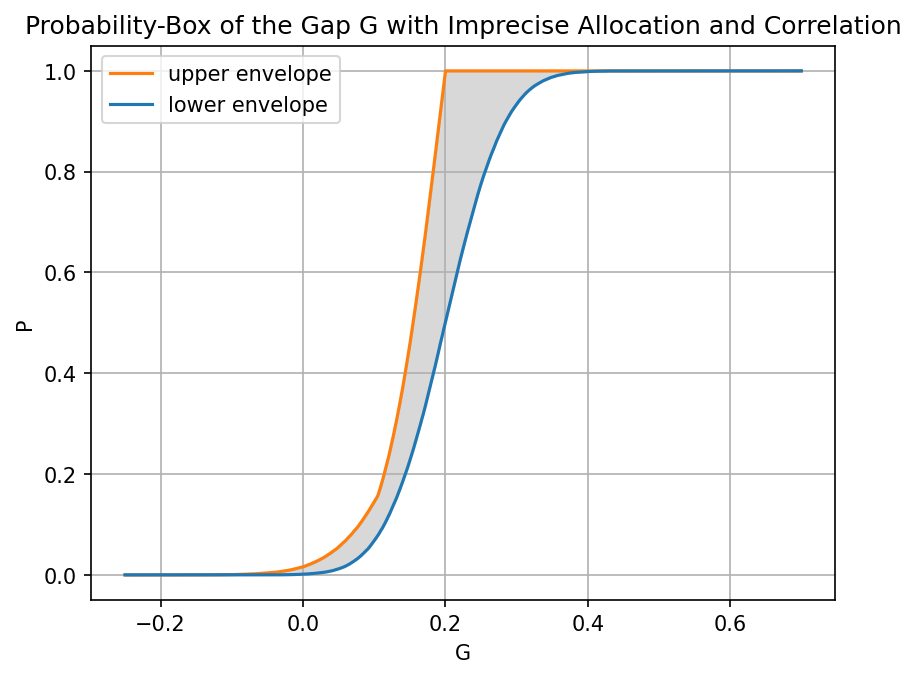

In [16]:
# %matplotlib qt
fig31 = plt.figure(dpi=150)

ax31 = fig31.add_subplot(1, 1, 1)
ax31.plot(sup_data_corr[:, 0], sup_data_corr[:, 1], color="tab:orange", label="upper envelope")
ax31.plot(inf_data_corr[:, 0], inf_data_corr[:, 1], color="tab:blue", label="lower envelope")
ax31.grid(True)
ax31.fill_between(
    inf_data_corr[:, 0], inf_data_corr[:, 1], sup_data_corr[:, 1], color="gray", alpha=0.3
)
ax31.set_xlabel("G")
ax31.set_ylabel("P")
ax31.legend()
ax31.set_title("Probability-Box of the Gap G with Imprecise Allocation and Correlation")
# otaf.plotting.save_plot(filename="PBoxGapGImpreciseAllocationCorrelation", ax=ax31, dpi=600)
plt.plot()

In [17]:
pf_min = otaf.distribution.get_prob_below_threshold(inf_data_corr)
pf_max = otaf.distribution.get_prob_below_threshold(sup_data_corr)
print(f"Minimum failure probability: {pf_min:.5e}\n Maximum failure probability: {pf_max:.5e}")

Minimum failure probability: 1.39000e-03
 Maximum failure probability: 1.60200e-02


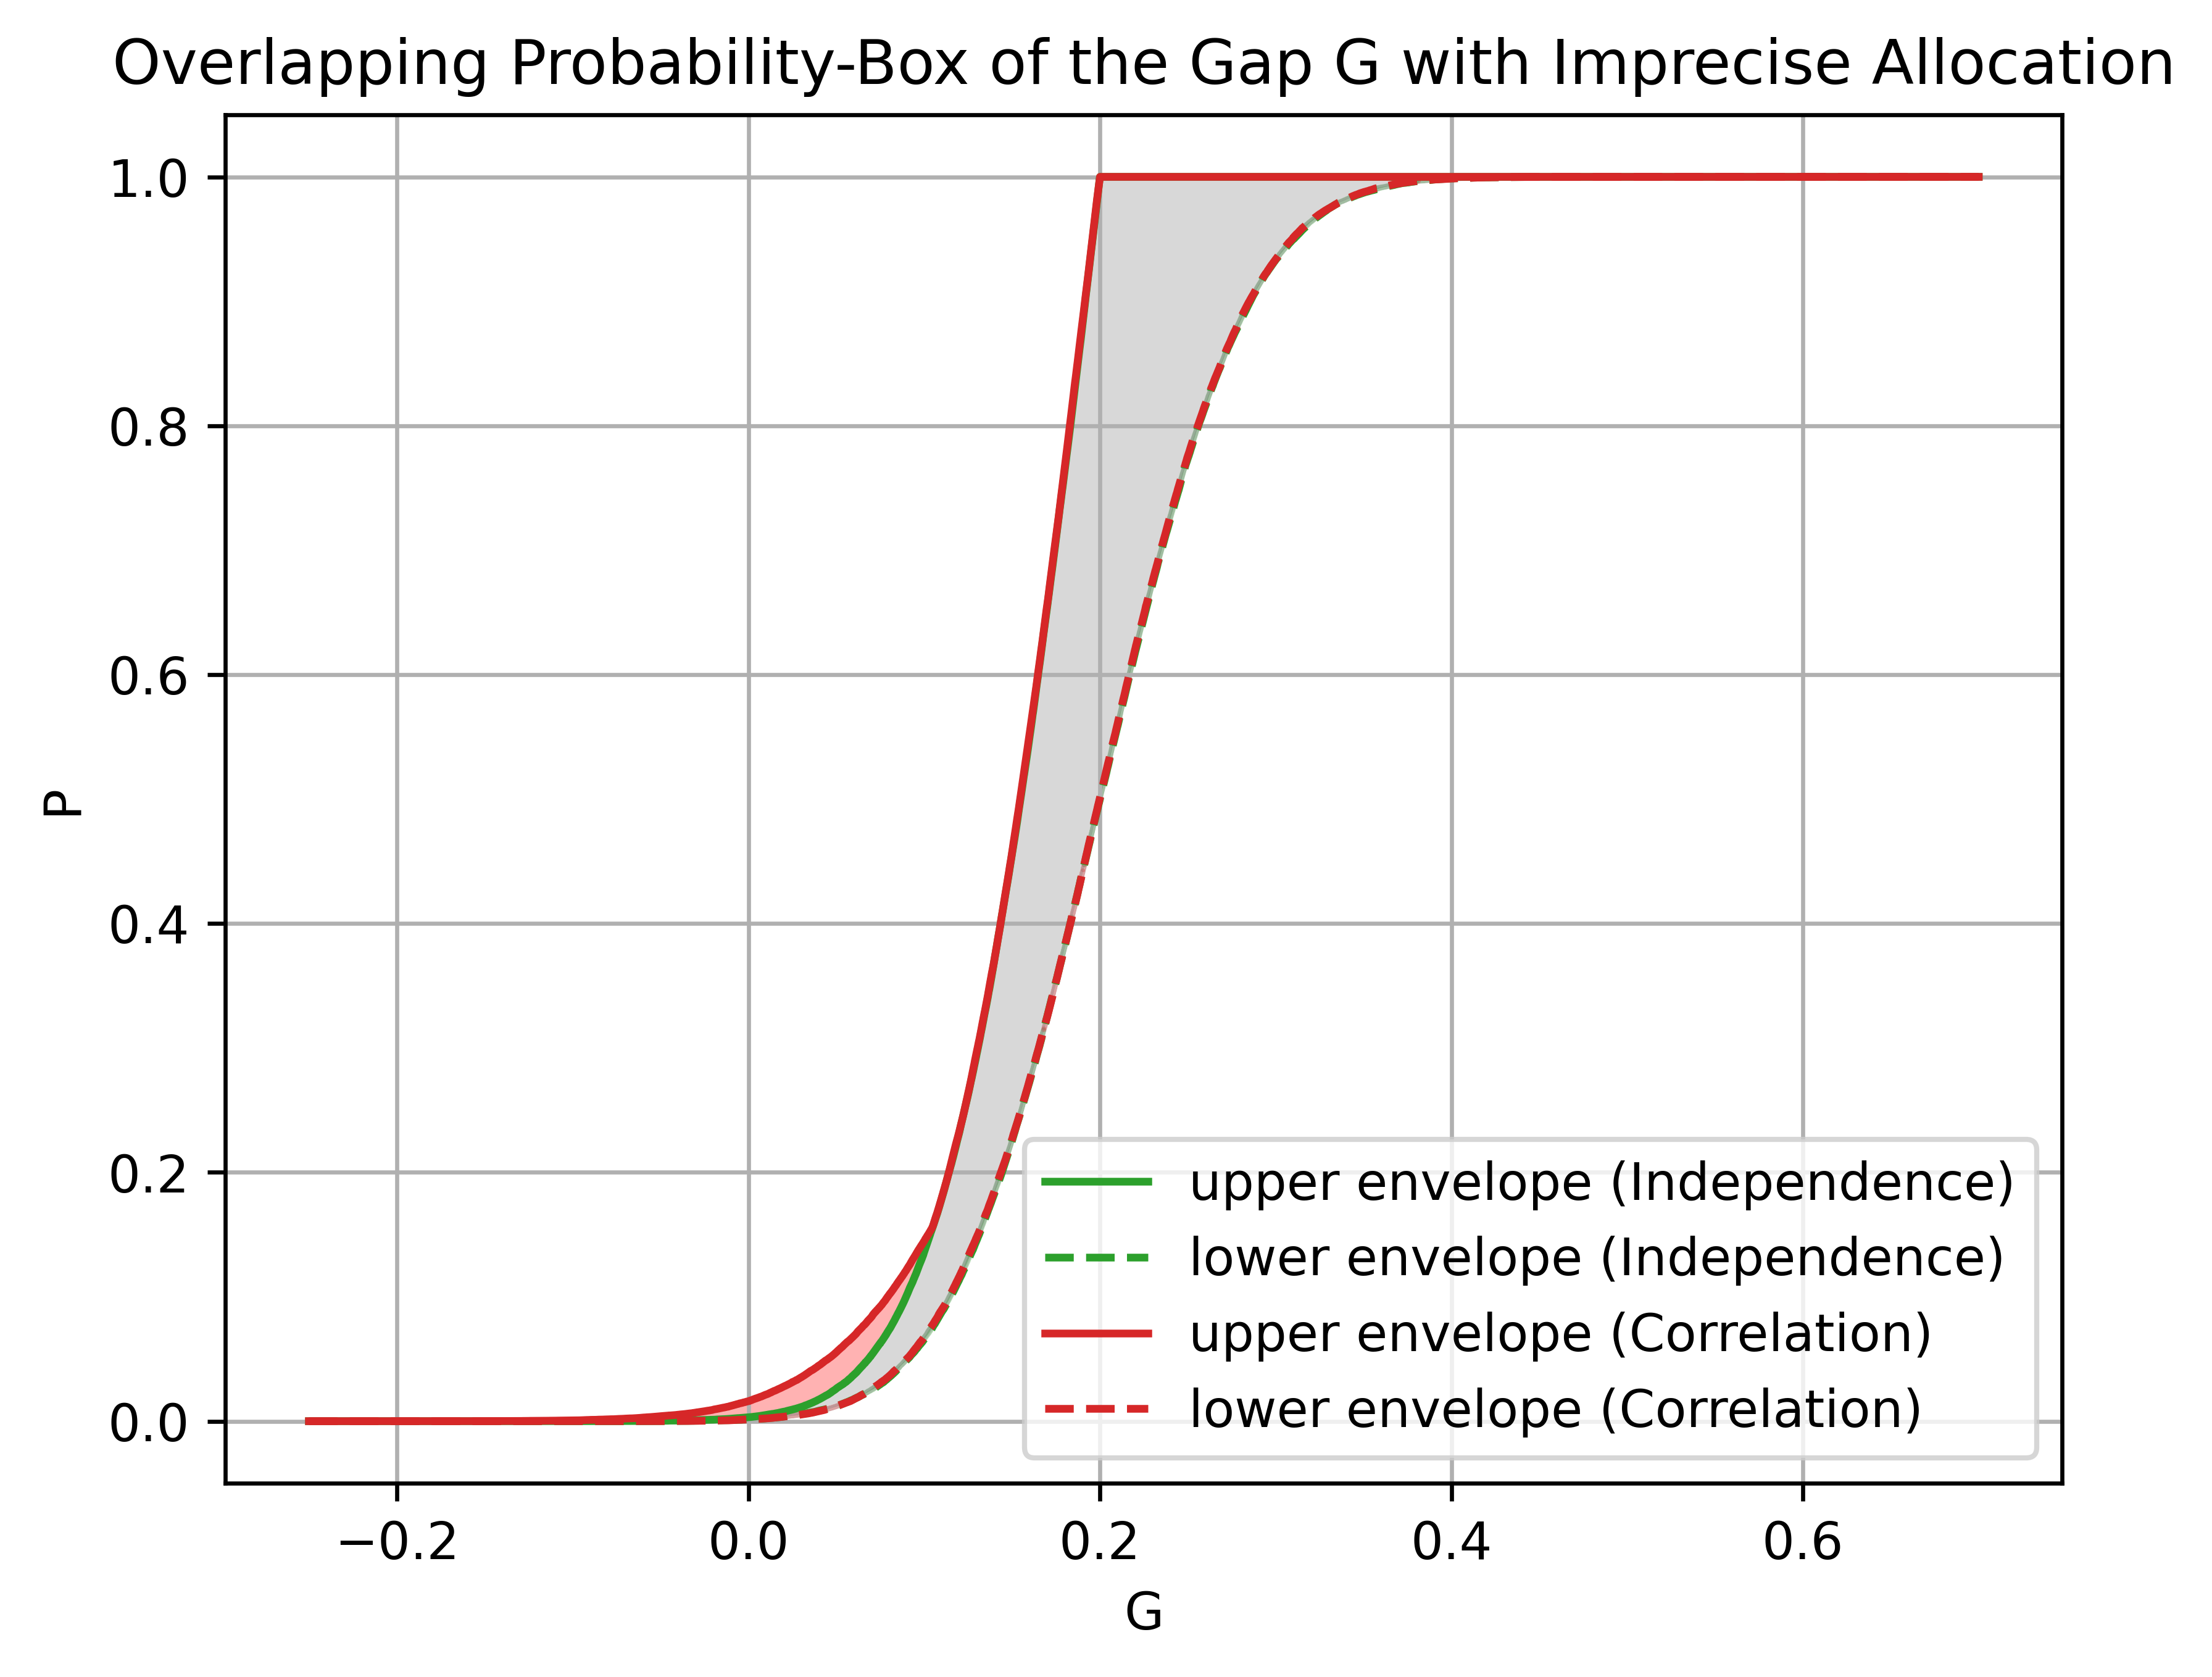

In [18]:
# Create the new figure
fig_overlap = plt.figure(dpi=600)
ax_overlap = fig_overlap.add_subplot(1, 1, 1)

# Plot the upper and lower envelopes for both correlation and independence
ax_overlap.plot(sup_data_nocorr[:, 0], sup_data_nocorr[:, 1], color="tab:green", label="upper envelope (Independence)")
ax_overlap.plot(inf_data_nocorr[:, 0], inf_data_nocorr[:, 1], color="tab:green", linestyle='--', label="lower envelope (Independence)")

ax_overlap.plot(sup_data_corr[:, 0], sup_data_corr[:, 1], color="tab:red", label="upper envelope (Correlation)")
ax_overlap.plot(inf_data_corr[:, 0], inf_data_corr[:, 1], color="tab:red", linestyle='--', label="lower envelope (Correlation)")

# Grid
ax_overlap.grid(True)

# Define arrays for gap values and bounds
g_vals = sup_data_nocorr[:, 0]
li = inf_data_nocorr[:, 1]  # Lower bound for Independence
lc = inf_data_corr[:, 1]  # Lower bound for Correlation
ui = sup_data_nocorr[:, 1]  # Upper bound for Independence
uc = sup_data_corr[:, 1]  # Upper bound for Correlation

# Masks for the different regions
# Green: Independence dominates (li < lc) or (ui > uc)
mask_green_lower = li < lc
mask_green_upper = ui > uc

# Red: Correlation dominates (lc < li) or (uc > ui)
mask_red_lower = lc < li
mask_red_upper = uc > ui

# Gray: Overlapping regions (li < uc) and (lc < ui)
mask_gray = (li < uc) & (lc < ui)

# Fill regions based on the masks
# Green regions
ax_overlap.fill_between(g_vals, li, lc, where=mask_green_lower, color="green", alpha=0.3)
ax_overlap.fill_between(g_vals, uc, ui, where=mask_green_upper, color="green", alpha=0.3)

# Red regions
ax_overlap.fill_between(g_vals, lc, li, where=mask_red_lower, color="red", alpha=0.3)
ax_overlap.fill_between(g_vals, ui, uc, where=mask_red_upper, color="red", alpha=0.3)

# Gray regions (overlap)
ax_overlap.fill_between(g_vals, np.maximum(li, lc), np.minimum(ui, uc), where=mask_gray, color="gray", alpha=0.3)

# Set labels and title
ax_overlap.set_xlabel("G")
ax_overlap.set_ylabel("P")
ax_overlap.set_title("Overlapping Probability-Box of the Gap G with Imprecise Allocation")

# Add legend
ax_overlap.legend()

# Show the plot
plt.show()
